# Sampling a normal using a t

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Generating samples from N(0,1)

In what I call ny "fake-news" examples, we are going to generate samples from $N(0,1)$ using a t-distribution with 2 degrees of freedom to majorize it.

In [2]:
from scipy.stats import norm, t
n = norm()
t2 = t(2)

Here is a plot of the two distributions. Note that since the t has larger tails, it is shorter than the normal in the middle..we also make a rugplot of samples from the t, since we will be using these samples

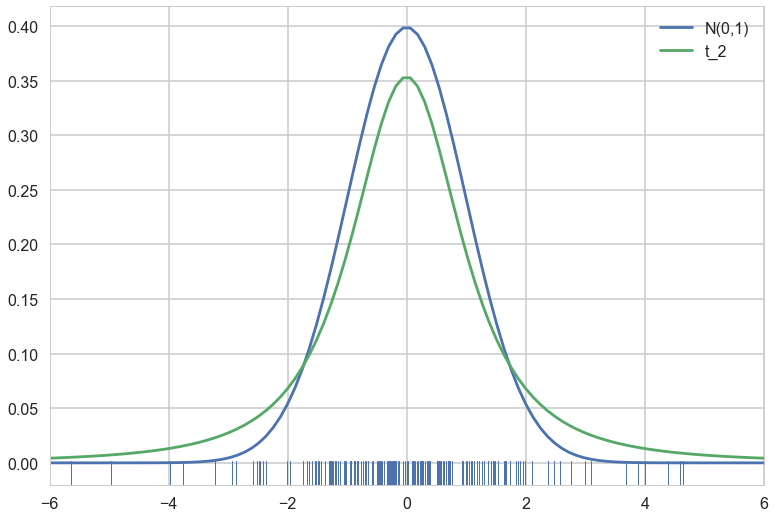

In [3]:
with sns.plotting_context('poster'):
    xx = np.linspace(-6., 6., 100)
    plt.plot(xx, n.pdf(xx), label='N(0,1)');
    plt.plot(xx, t2.pdf(xx), label = 't_2');
    t2samps = t2.rvs(200)
    ax = plt.gca()
    sns.rugplot(t2samps, ax=ax);
    plt.xlim(-6, 6)
    plt.legend();

We are interested  in finding the $f/g$ for these distributions, since we will want to set $M$ to the supremum of this ratio across the domain we are interested in

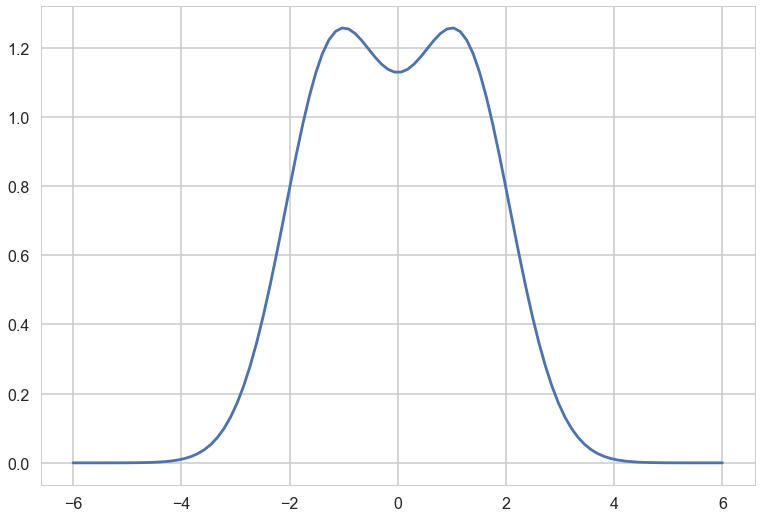

In [4]:
fbyg = n.pdf(xx)/t2.pdf(xx)
plt.plot(xx, fbyg);

As you can see, the supremum is achived at two points. Lets get one and thus the $M$.

In [5]:
# get index where maximized, then index into fbyg
M = fbyg[np.argmax(fbyg)]
M

1.2569255634535634

Lets rescale the t by $M$ and plot it so that we can see the majorization. 

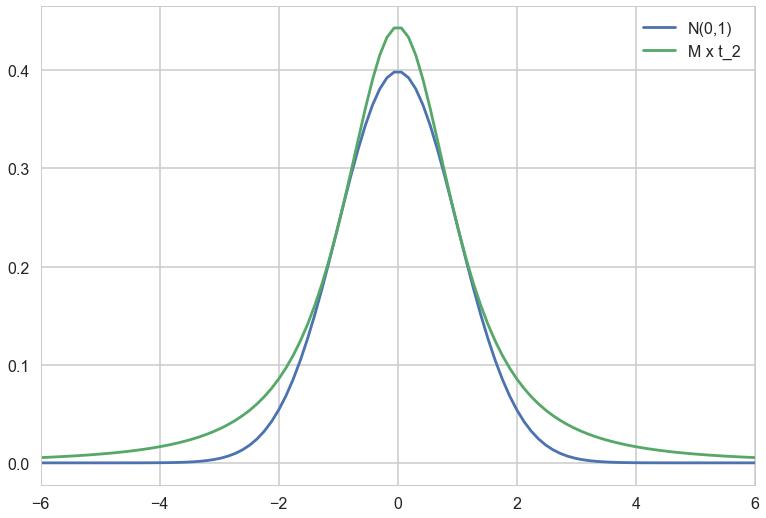

In [6]:
with sns.plotting_context('poster'):
    xx = np.linspace(-6., 6., 100)
    plt.plot(xx, n.pdf(xx), label='N(0,1)');
    plt.plot(xx, M*t2.pdf(xx), label = 'M x t_2');
    plt.xlim(-6, 6)
    plt.legend();

Green curve now majorizes blue curve, so can use for rejection sampling.
Caveat: need to maintain domain, throw out anything not in between -6 and 6.

## Rejection Sampling Implementation

Count 12183 Accepted 10000 Outside 313


C:\Users\Jackie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


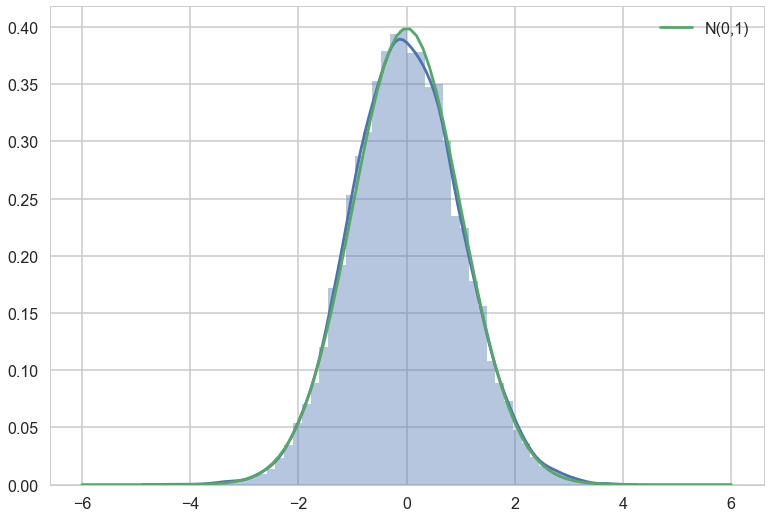

In [7]:
# domain limits
xmin = -6 # the lower limit of our domain
xmax = 6 # the upper limit of our domain

N = 10000 # the total of samples we wish to generate
accepted = 0 # the number of accepted samples
samples = np.zeros(N)
count = 0 # the total count of proposals
outside = 0
f = norm.pdf
g = t2.pdf

# generation loop
while (accepted < N):
    
    while 1:
        xproposal = t2.rvs()
        if xproposal > xmin and xproposal < xmax:
            break
        # if not in range, must be outside
        outside+=1
        # dangerous code bc what if infinite support? just do this in rejection sampling
    # pick a uniform number on [0, 1). essentially sampling ys along height of f, then check if lower than g.
    y = np.random.uniform(0,1)
    
    # Do the accept/reject comparison
    if y < f(xproposal)/(M*g(xproposal)): #if wasn't dividing by M*g here, would have to change limits of uniform
        samples[accepted] = xproposal
        accepted += 1
    
    count +=1
    
print("Count", count, "Accepted", accepted, "Outside", outside)



# plot the histogram
sns.distplot(samples);
plt.plot(xx, n.pdf(xx), label='N(0,1)');


# turn on the legend
plt.legend();

Notice that the number of rejected samples is roughly 2500. This is because the probability of acceptance is $1/M$.

## Expectation values

Lets calculate the expectation value $$E_f[h]$$ using the rejection samples obtained.

Here is a $h$:

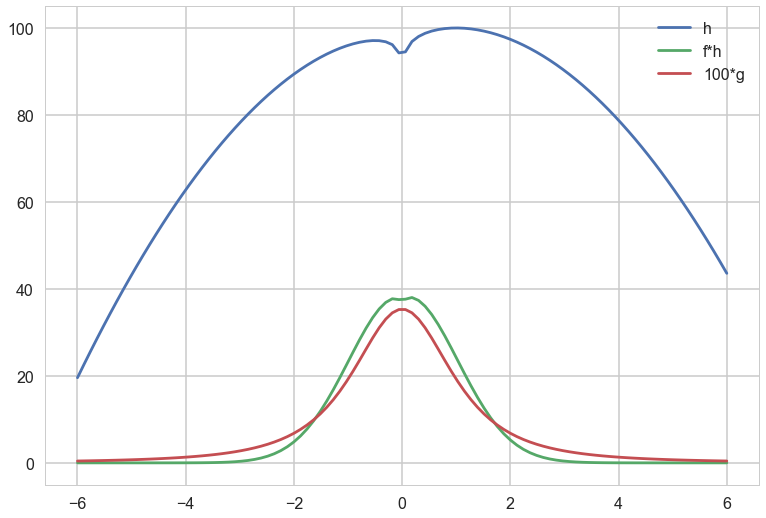

In [8]:
hfun = lambda x: np.log(x**2) - 2*x**2 +2*x +100
plt.plot(xx, hfun(xx), label='h');
plt.plot(xx, f(xx)*hfun(xx), label='f*h');
plt.plot(xx, 100*g(xx), label = '100*g')
plt.legend();

and here is its expectation:

In [9]:
exp_f_of_h = np.mean(hfun(samples))
exp_f_of_h

96.705391414361912

## Expectations from Importance Sampling

Remember that in imporance sampling we are calculating

$$E_f[h(x)] = E_g[ \frac{f(x)}{g(x)} h(x)] = E_g[w(x)h(x)]$$

where

$$w(x) = f(x)/g(x)$$

All of this only works if f and g are normalized pdfs. If not, w will be wrong.

New constraint that you don't have to worry about with rejection sampling. But, benefit: not throwing away as many samples anymore.

In [10]:
t2.cdf(6) - t2.cdf(-6), n.cdf(6) - n.cdf(-6)

(0.97332852678457527, 0.9999999980268246)

In [11]:
normer = (t2.cdf(6) - t2.cdf(-6))/(n.cdf(6) - n.cdf(-6))
normer

0.97332852870512321

In [12]:
t2samps = t2.rvs(10300)
t2samps = t2samps[ (t2samps<xmax) & (t2samps>xmin)] #restrict to appropriately normalized range
print(t2samps.shape)
fbygfunc = lambda x: (normer*n.pdf(x))/t2.pdf(x)
expec = np.mean(hfun(t2samps)*fbygfunc(t2samps))
expec

(10020,)


96.920694833277963

Importance sampling supposed to reduce variance, but this is still pretty variable.

## Some notes on variance 

Lets check the "vanilla" monte-carlo variance

In [13]:
vanilla=[]
for k in range(1000):
    vm = np.mean(hfun(n.rvs(2000)))
    vanilla.append(vm)
np.mean(vanilla), np.std(vanilla)

(96.731260557942662, 0.065825856056207194)

Lets compare the importance sampler's variance:

In [14]:
eval_is=[]
for k in range(1000):
    t2samps = t2.rvs(1000)
    t2samps = t2samps[ (t2samps<xmax) & (t2samps>xmin)]
    fbygfunc = lambda x: (normer*n.pdf(x))/t2.pdf(x)
    expec = np.mean((hfun(t2samps)*fbygfunc(t2samps)))
    eval_is.append(expec)

In [15]:
np.mean(eval_is), np.std(eval_is)

(96.702753413644302, 1.0914569479961271)

## A different importance sampling estimator

Wow, look at the variance, its really high. An alternative to the standard importance sampling estimator ( $(1/N) \sum_{x_i \sim g} w(x_i) h(x_i)$ ) is the "self normalized" estimator:

$$\frac{\sum_{x_i \sim g} w(x_i) h(x_i)}{\sum_{x_i \sim g} w(x_i)}$$

Notice that in the limit $N \to \infty$, the denominator converges to 1 and the entire expectation to out usual case. But in the case of a finite number of samples (and worse for smaller sample sizes), this latter estimator is much more stable, leading to lower variance. Lets try it (we have only 1000 samples)

Including variance in denominator helps normalize the variance in the numerator. 1st estimator is unbiased, 2nd estimator is biased. Suggested way of dealing: try 1st estimator 1st, see what variance looks like. If too high, THEN try 2nd instead.

In [16]:
eval_is=[]
for k in range(1000):
    t2samps = t2.rvs(1000)
    t2samps = t2samps[ (t2samps<xmax) & (t2samps>xmin)]
    fbygfunc = lambda x: (n.pdf(x))/t2.pdf(x)
    expec = np.mean((hfun(t2samps)*fbygfunc(t2samps)))
    expec = expec/np.mean(fbygfunc(t2samps))
    eval_is.append(expec)

In [17]:
np.mean(eval_is), np.std(eval_is)

(96.729544617591628, 0.089178514779999246)

I leave further experimentation, including trying other h and g, to you.